In [ ]:
# Kaggle'dan veri aktaracağımız için Kaggle hesabımdan API key'in olduğu kaggle.json dosyasını colab'e yükle
from google.colab import files
files.upload()


{}

In [ ]:
# .kaggle diye directory varsa sil ve tekrar yarat
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/ # kaggle.json'ı .kaggle klasörü içine koy
!chmod 600 ~/.kaggle/kaggle.json # izinleri private yap


mv: cannot stat './kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# Dataset'i indir(Dataset sayfasında dowload yanındaki 3 noktadan "Copy API command'i seçin")
!kaggle datasets download -d mirichoi0218/insurance

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [88]:
# İndirilen dataset zip dosyasını ayıkla
import zipfile
zip_ref = zipfile.ZipFile('insurance.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [89]:
# Gerekli libraryleri import et
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV


In [90]:
# Dataseti okuyup dataframe'e koy
data = pd.read_csv("insurance.zip")


In [91]:
print(data.head())


   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [92]:
print(data.columns)


Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')


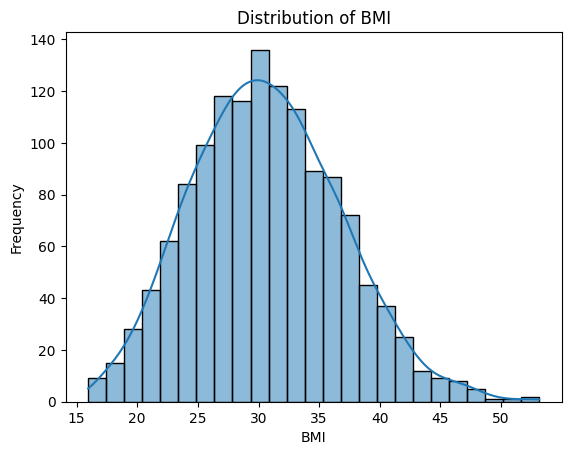

In [93]:
# Examine the distribution of BMI (Body Mass Index)
sns.histplot(data['bmi'], kde=True)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()
# Yorum: BMI'nin dağılımı neredeyse obezlerde fazlalık olduğuna işaret ediyor.

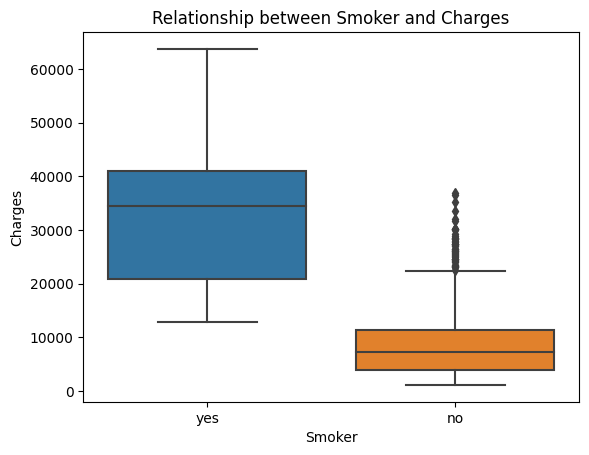

In [94]:
# Examine the relationship between "smoker" and "charges"
sns.boxplot(x='smoker', y='charges', data=data)
plt.title('Relationship between Smoker and Charges')
plt.xlabel('Smoker')
plt.ylabel('Charges')
plt.show()
# Yorum: Sigara içenlerin sağlık sigortası maliyetleri, içmeyenlere göre genellikle daha yüksektir.

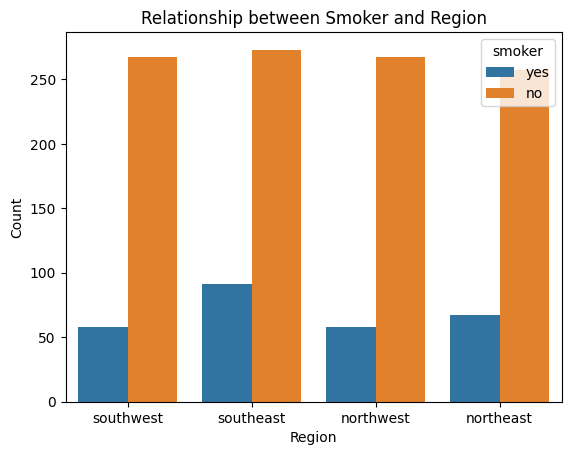

In [95]:
# Examine the relationship between "smoker" and "region"
sns.countplot(x='region', hue='smoker', data=data)
plt.title('Relationship between Smoker and Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()
# Yorum: Sigara içme oranı bölgeye göre farklılık göstermektedir. Özellikle güneydoğu bölgesinde daha fazla sigara içenler vardır.

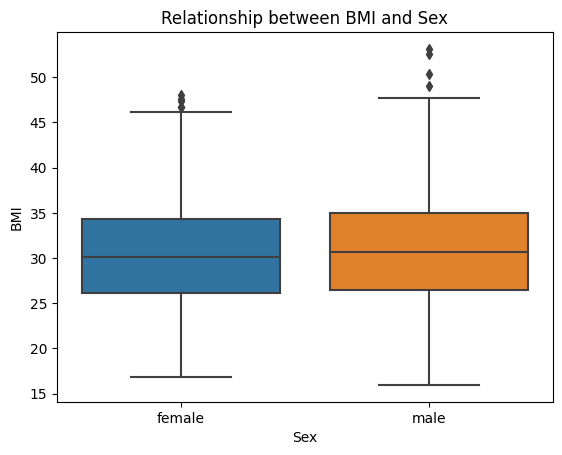

In [96]:
# Examine the relationship between "bmi" and "sex"
sns.boxplot(x='sex', y='bmi', data=data)
plt.title('Relationship between BMI and Sex')
plt.xlabel('Sex')
plt.ylabel('BMI')
plt.show()
# Yorum: Cinsiyetin BMI üzerinde belirgin bir etkisi yok gibi görünüyor.

In [100]:
# Find the "region" with the most "children"
region_with_most_children = data.groupby('region')['children'].sum().idxmax()
print(f"En çok çocuklu region {region_with_most_children}.")
# Yorum: En fazla çocuğa sahip bölge, kuzeybatı bölgesidir.

En çok çocuklu region southeast.


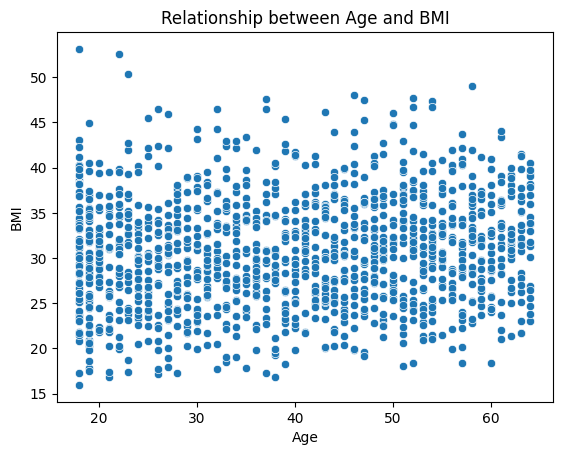

In [101]:
# Examine the relationship between "age" and "bmi"
sns.scatterplot(x='age', y='bmi', data=data)
plt.title('Relationship between Age and BMI')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.show()
# Yorum: Yaşın BMI üzerinde belirgin bir etkisi yok gibi görünüyor. Her grup eşit dağılmış gibi

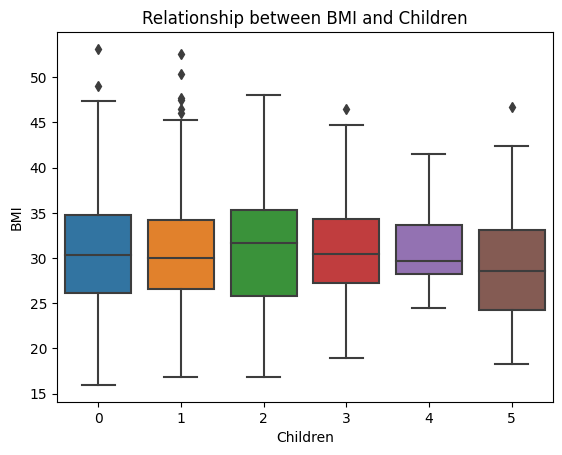

In [102]:
# Examine the relationship between "bmi" and "children"
sns.boxplot(x='children', y='bmi', data=data)
plt.title('Relationship between BMI and Children')
plt.xlabel('Children')
plt.ylabel('BMI')
plt.show()
# Yorum: Çocuk sayısının BMI üzerinde çok fazla etkisi yok gibi gözüküyor

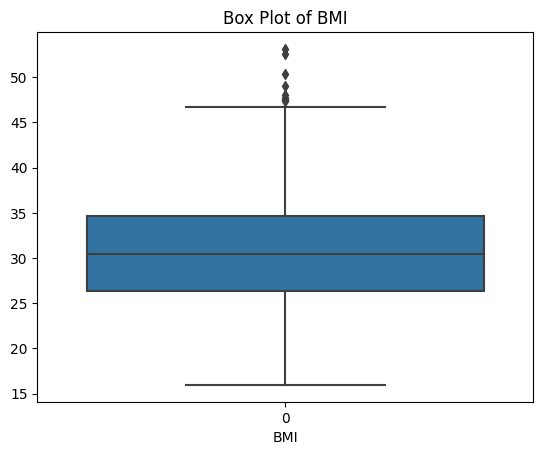

In [103]:
# Check for outliers in the "bmi" variable
sns.boxplot(data['bmi'])
plt.title('Box Plot of BMI')
plt.xlabel('BMI')
plt.show()
# Yorum: BMI verilerinde aykırı değerler(outlier) bulunmaktadır

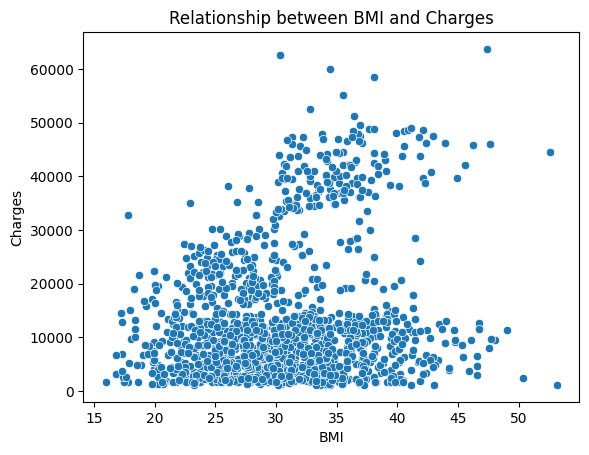

In [104]:
# Examine the relationship between "bmi" and "charges"
sns.scatterplot(x='bmi', y='charges', data=data)
plt.title('Relationship between BMI and Charges')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.show()
# Yorum: BMI'nin artması, sağlık sigortası maliyetlerinin artma eğiliminde olduğunu gösteriyor.

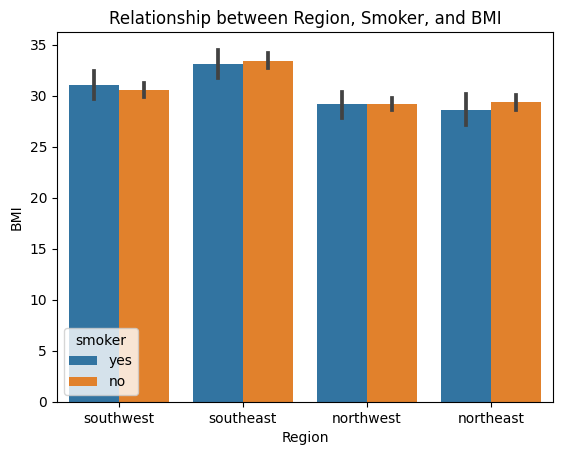

In [105]:
# Examine the relationship between "region", "smoker", and "bmi" using a bar plot
sns.barplot(x='region', y='bmi', hue='smoker', data=data)
plt.title('Relationship between Region, Smoker, and BMI')
plt.xlabel('Region')
plt.ylabel('BMI')
plt.show()
# Yorum: Sigara içenlerin BMI değerleri, içmeyenlere göre bölgeye göre değişiklik göstermektedir.

In [106]:
#  "sex" ve "smoker" sütunlarını LabelEncode et
label_encoder = LabelEncoder()
data['sex'] = label_encoder.fit_transform(data['sex'])
data['smoker'] = label_encoder.fit_transform(data['smoker'])

# One-hot encoding "region"
data = pd.get_dummies(data, columns=['region'], prefix='region', drop_first=True)

# Veriyi feature X ve target Y ye ayır
X = data.drop(columns=['charges'])
y = data['charges']

# Training ve testing datasetlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# StandardScaler kullanarak scale et
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [107]:
# Farklı modelleri ayarla
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Support Vector Machine': SVR()
}

# Cross validation ile en iyi modeli seç
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f"{model_name} RMSE: {np.mean(rmse_scores):.2f}")


Linear Regression RMSE: 6147.09
Random Forest RMSE: 4975.84
Support Vector Machine RMSE: 12566.80


In [108]:
# En iyi model Random Forest çıkmıştır bu sepele onu seçiyoruz
# GridSearch ile hyperparameter optimization yap
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# En iyi parametereler ve estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}


Mean Squared Error: 19102068.98
Root Mean Squared Error: 4370.59
Mean Absolute Error: 2508.89


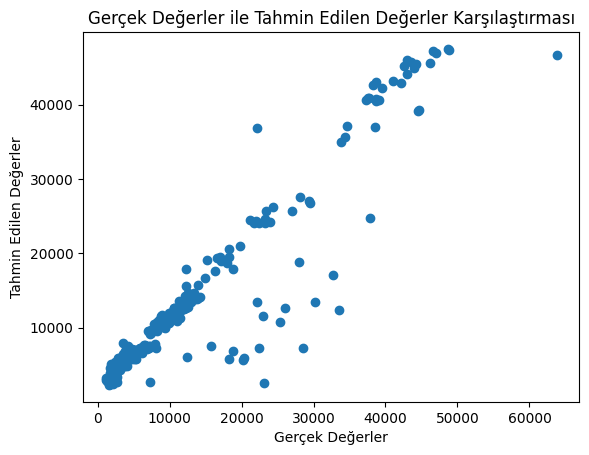

In [109]:
# Evaluation
y_pred = best_estimator.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

# Tahmin edilen vs. asıl değerler
plt.scatter(y_test, y_pred)
plt.title('Gerçek Değerler ile Tahmin Edilen Değerler Karşılaştırması')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.show()


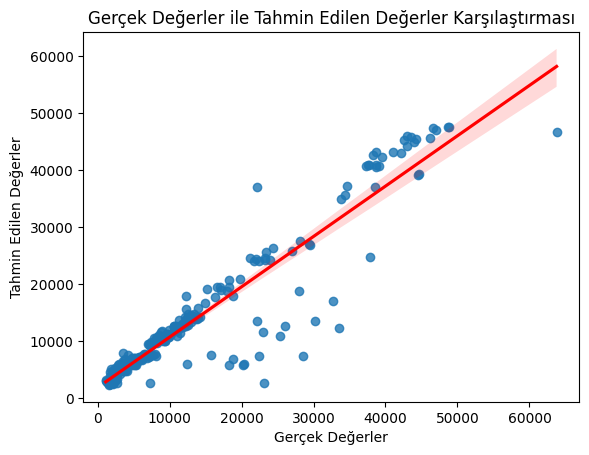

In [110]:
# En iyi fit i gösteren çizgiyi çek
sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red"})
plt.title('Gerçek Değerler ile Tahmin Edilen Değerler Karşılaştırması')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.show()


In [ ]:
# Bootcamp için TEŞEKKÜRLER